# Imports, Hardware Parameters & Global Configuration

In [1]:
#Astro-specific
from astropy.io import fits #For working with FITS files
from astropy.modeling import models, fitting #For fitting a 2D Gaussian

#General functions
import numpy as np #Calculations
from scipy import stats #For regressions and confidence intervals
import os #File operations

#Utilities
import matplotlib.pyplot as plt #Plotting
import tqdm #Progress bars
import concurrent.futures #Parallel processing


#User-defined

num_cores = 8 #Maximal number of cores to use for parallel processing. Set to 1 to disable parallel processing.

# Master Flat and Darks

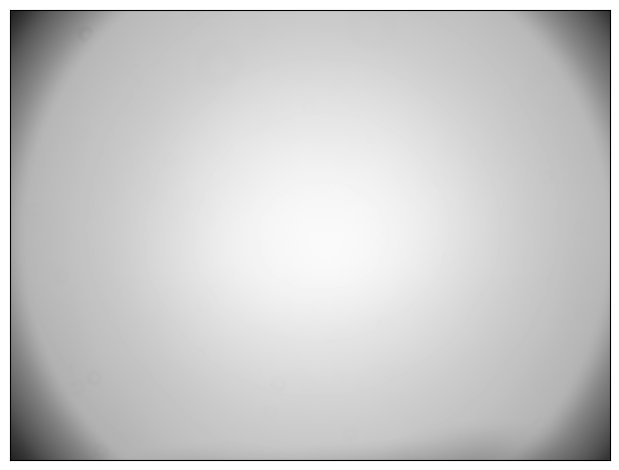

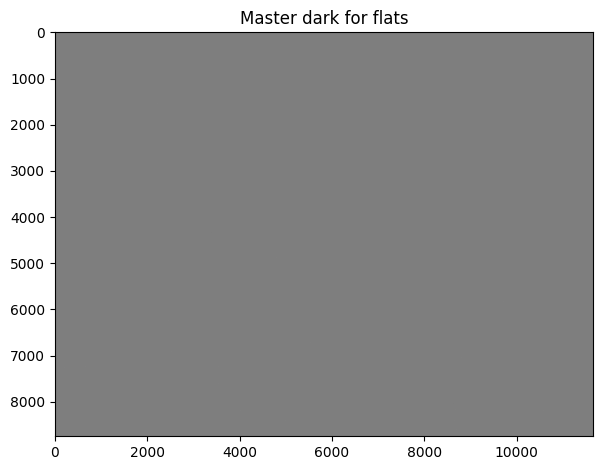

In [5]:
#Create a master flat file

#Parameters:
#Directory with the flats files
flatdir = '../Data/2024-03-19/FLATS/FLAT/C/'
#Directory with the dark files
darkdir = '../Data/2024-03-19/FLATS/DARK/'
#Path to result file
resultfile = '../Data/2024-03-19/FLATS/FLAT/C/masterFlat.fits'

#Dimensions of the pictures
height = 11664
width = 8750

#Width of slice for parsing the files
slice = 1750
assert(width % slice == 0), 'Width must be a multiple of slice'

### Computations ###

#List the flat and dark files
flatfiles = os.listdir(flatdir)
darkfiles = os.listdir(darkdir)

#Initialisation
masterDark = np.zeros((width, height))

#Calculating the master dark
for i in range(int(width / slice)):
    j = i * slice
    k = j + slice
    stack = np.zeros((slice, height, len(darkfiles)))
    n = 0
    for filename in darkfiles:
        with fits.open(darkdir + filename) as hdul:
            #hdul.info()
            stack[:,:,n] = hdul[0].section[j:k,:]
        n += 1
    masterDark[j:k,:] = np.median(stack, axis=2)

#Initialisation
masterFlat = np.zeros((width, height))

#Calculating the master flat
for i in range(int(width / slice)):
    j = i * slice
    k = j + slice
    stack = np.zeros((slice, height, len(flatfiles)))
    n = 0
    for filename in flatfiles:
        if filename == 'masterFlat.fits': continue #Skip master flat file if already created
        with fits.open(flatdir + filename) as hdul:
            #hdul.info()
            stack[:,:,n] = hdul[0].section[j:k,:] - masterDark[j:k,:] #Directly subtract masterDark
        n += 1
    masterFlat[j:k,:] = np.median(stack, axis=2)

#Normalize master flat:
masterFlat /= np.mean(masterFlat)

#Create header
header = fits.getheader(flatdir + flatfiles[0])
header['DESC'] = 'Master flat, dark subtracted and normalized'

#Display results for visual check
plt.imshow(masterFlat, cmap='gray')
plt.title('Master flat') #Image included in the report has no title and no ticks                
#plt.xticks([])
#plt.yticks([])
plt.tight_layout()
plt.savefig('../Results/masterFlat.pdf', format='pdf')
plt.show()

plt.imshow(masterDark, cmap='gray')
plt.title('Master dark for flats')
plt.tight_layout()
plt.savefig('../Results/masterDarkFlats.pdf', format='pdf')
plt.show()


#Save results
#fits.writeto(resultfile, masterFlat, header=header, overwrite=True)

# Bias VS Gain

Frame slices for gain zero: 100%|██████████| 25/25 [02:24<00:00,  5.77s/it]


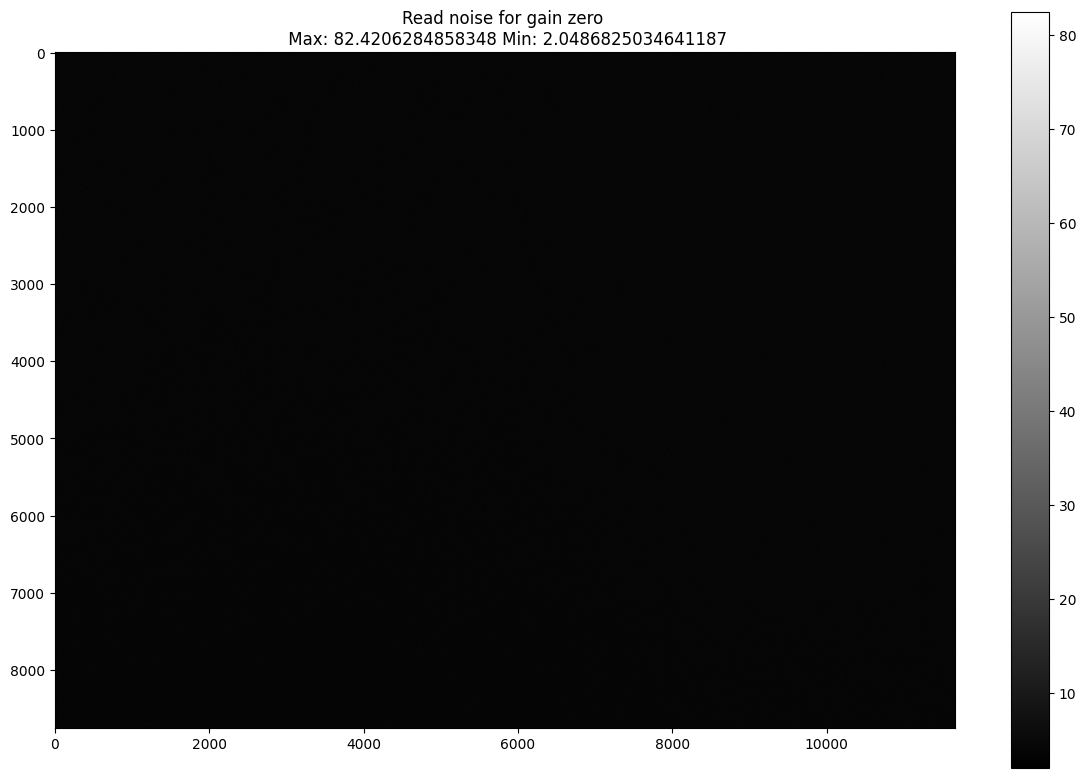

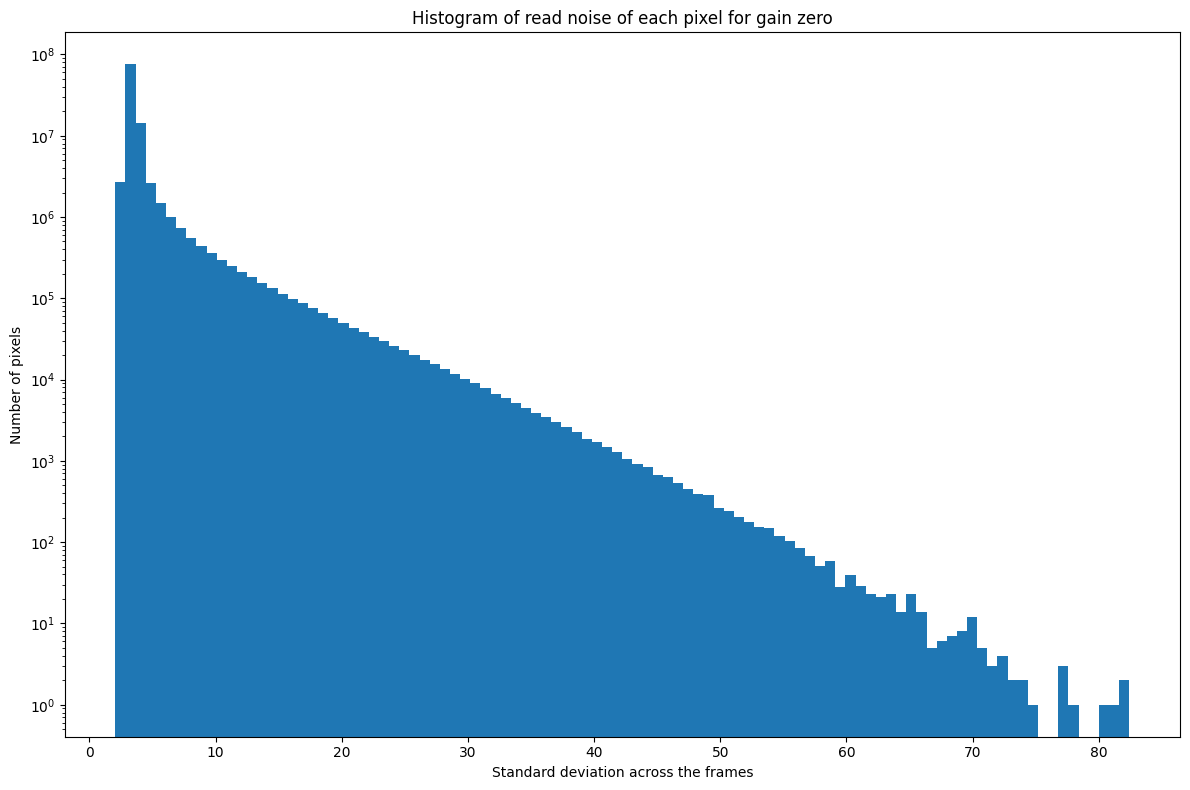

Other gain values:   0%|          | 0/12 [00:00<?, ?it/s]

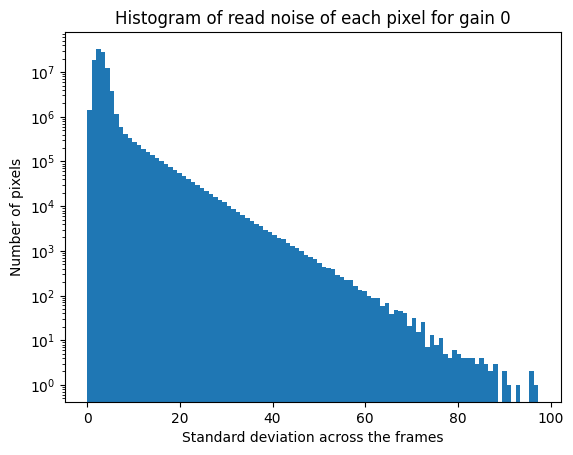

Other gain values:   8%|▊         | 1/12 [00:11<02:10, 11.82s/it]

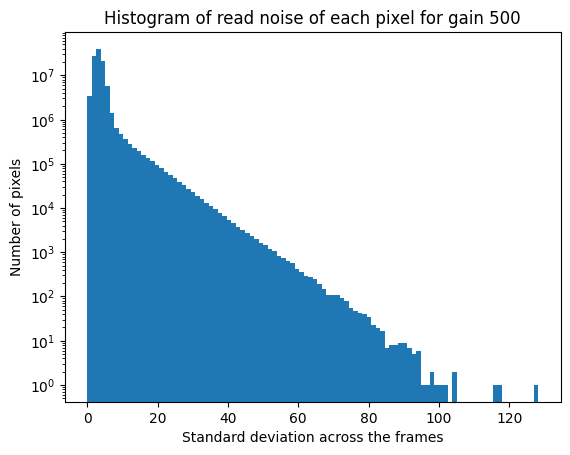

Other gain values:  17%|█▋        | 2/12 [00:22<01:51, 11.12s/it]

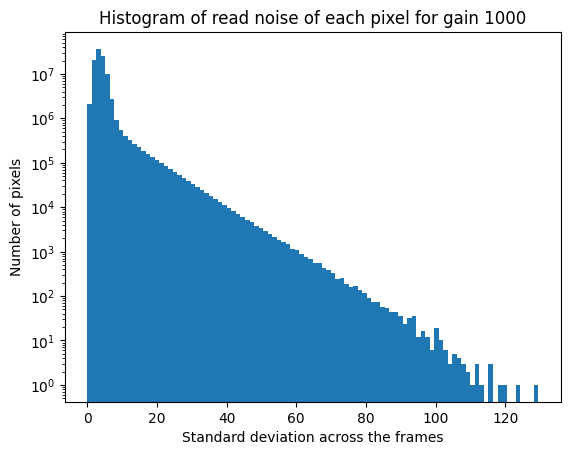

Other gain values:  25%|██▌       | 3/12 [00:33<01:39, 11.04s/it]

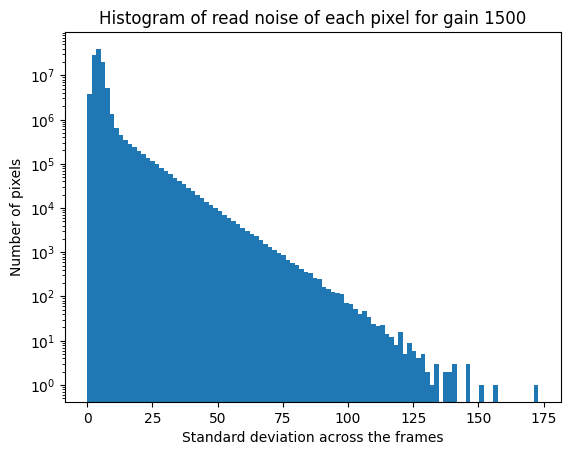

Other gain values:  33%|███▎      | 4/12 [00:44<01:29, 11.22s/it]

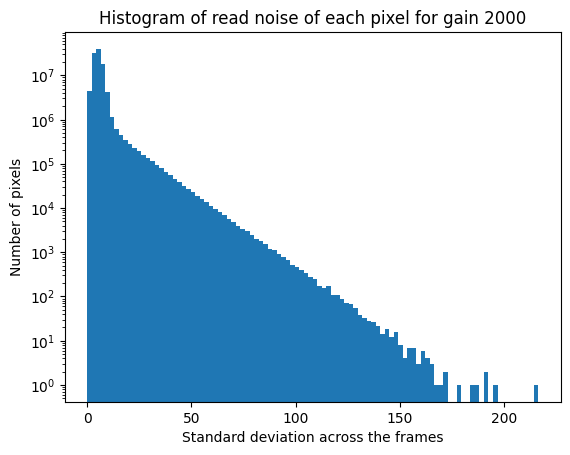

Other gain values:  42%|████▏     | 5/12 [00:54<01:13, 10.48s/it]

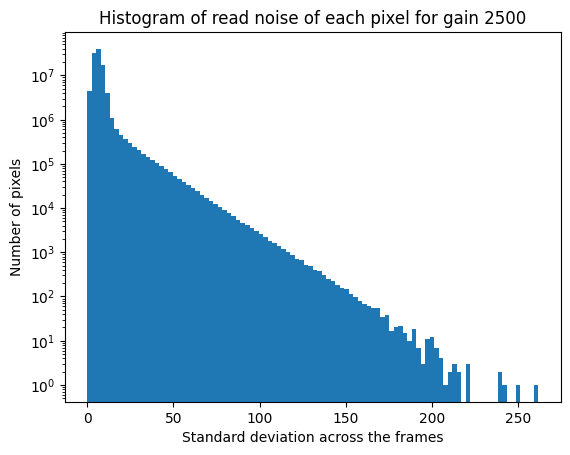

Other gain values:  50%|█████     | 6/12 [01:04<01:02, 10.40s/it]

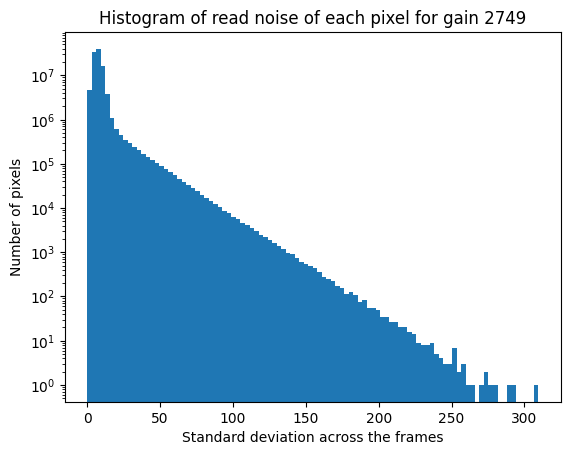

Other gain values:  58%|█████▊    | 7/12 [01:14<00:51, 10.35s/it]

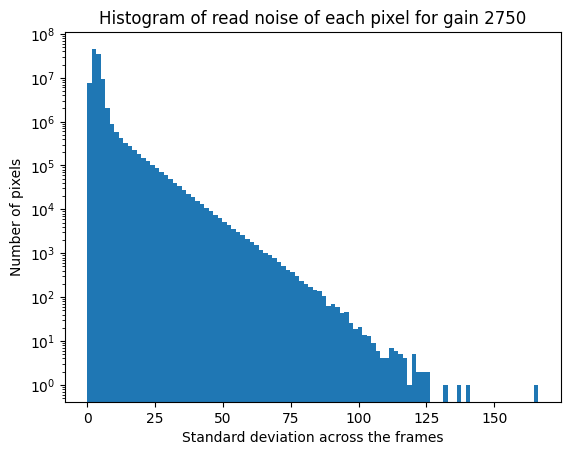

Other gain values:  67%|██████▋   | 8/12 [01:24<00:41, 10.36s/it]

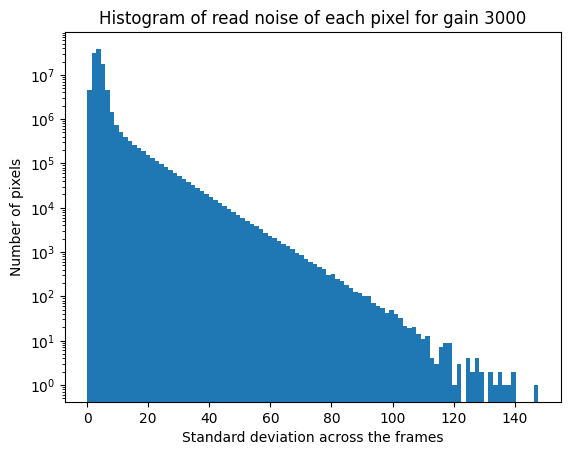

Other gain values:  75%|███████▌  | 9/12 [01:35<00:31, 10.43s/it]

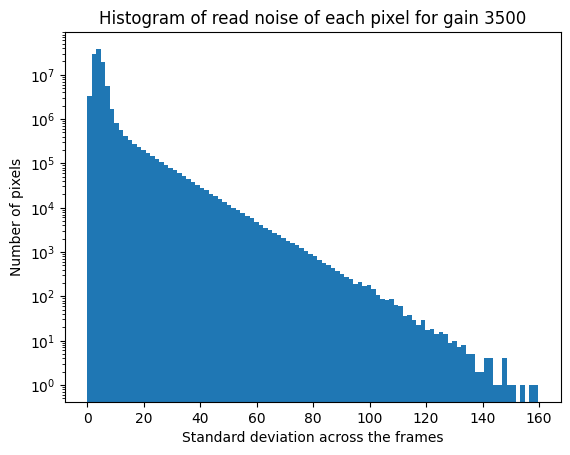

Other gain values:  83%|████████▎ | 10/12 [01:45<00:20, 10.34s/it]

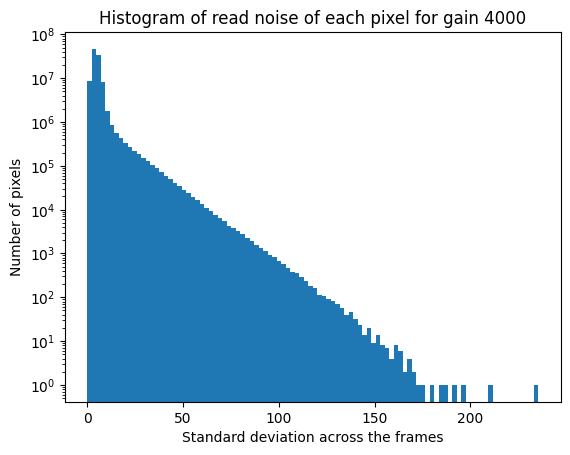

Other gain values:  92%|█████████▏| 11/12 [01:55<00:10, 10.26s/it]

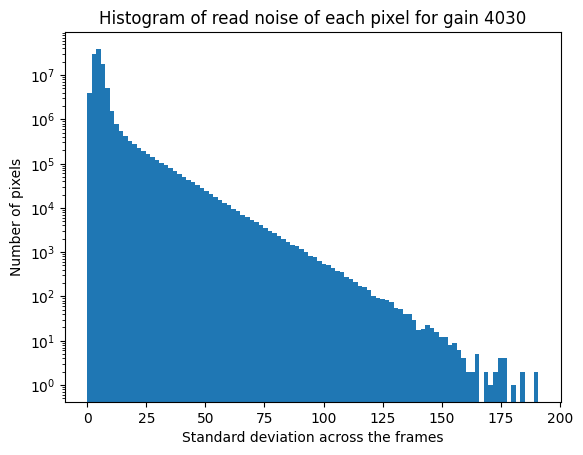

Other gain values: 100%|██████████| 12/12 [02:05<00:00, 10.49s/it]

Computations done! Run the plotting code in the next cell to display the results.


In [45]:
#TODO: decide on a good solution for the two values at gain 0

#Parameters
dirName = '../Data/2024-03-19/BiasVSGain/'
gainVal = [0, 500, 1000, 1500, 2000, 2500, 2749, 2750, 3000, 3500, 4000, 4030]
expNumb = 5 #Number of exposures for each gain value, smaller than 10

# For gain zero, there is a second set of measurements with 20x more data. This is handled separately.
dirZero = '../Data/2024-04-19/ReadOutNoise/' #Directory with the zero gain files

#Dimensions of the pictures
height = 11664
width = 8750

#Width of slice for parsing the gain zero files
slice = 350
assert(width % slice == 0), 'Width must be a multiple of slice'

### Computations ###
# Note: this can't be parallelized since the data is too big to fit in memory on my machine. It therefore takes a while to run. (~6')

#Initialisation
readNoise = np.zeros(len(gainVal) + 1) #+1 for gain second measurement of gain zero
RN_CI = np.zeros(len(gainVal) + 1)
t = stats.t.ppf(0.975, width * height - 1) #T-value for 95% confidence interval
pixNum = width * height #Number of pixels

#Equation for the confidence interval: CI = t * 1.253 * (1/n) * sqrt(sum(sigma^4 * 2 / (m - 1))) where sigma is the std-dev of the stack for each pixel, n is the number of pixels and m is the number of exposures. 1.253 is the correction factor for the median (from mean) since the sample is very large

#Gain zero with more data - This can't fit in memory all at once, so we have to do it in multiple slices
stdMat = np.zeros((width, height))
gain0files = os.listdir(dirZero)

for i in tqdm.tqdm(range(int(width / slice)), total=int(width / slice), desc='Frame slices for gain zero'):
    j = i * slice #Slice start
    k = j + slice #Slice end
    stack = np.zeros((len(gain0files), slice, height))

    n = 0 #Index for the stack
    for filename in gain0files: #Read the files where the current slice is and stack them
        with fits.open(dirZero + filename) as hdul:
            #hdul.info()
            stack[n,:,:] = hdul[0].section[j:k,:]
        n += 1

    stdMat[j:k,:] = np.std(stack, axis=0) #Calculate the standard deviations

readNoise[0] = np.median(stdMat)
RN_CI[0] = t * 1.253 * np.sqrt(np.sum(stdMat ** 4) * 2 / (len(gain0files) - 1)) / pixNum

#Display results for visual check: this should have no visible pattern
fig = plt.figure(figsize=(12, 8))
plt.imshow(stdMat, cmap='gray')
plt.title('Read noise for gain zero \n Max: ' + str(np.max(stdMat)) + ' Min: ' + str(np.min(stdMat)))
plt.colorbar()
plt.tight_layout()
plt.savefig('../Results/RN_gain0_spatial.pdf', format='pdf')
plt.show()

#Display histogram for visual check
fig = plt.figure(figsize=(12, 8))
plt.hist(stdMat.flatten(), bins=100, log=True)#Logarithmic scale: to see the low values
plt.xlabel('Standard deviation across the frames')
plt.ylabel('Number of pixels')
plt.title('Histogram of read noise of each pixel for gain zero')
plt.tight_layout()
plt.savefig('../Results/RN_gain0_hist.pdf', format='pdf')
plt.show()

del stdMat #Free memory

#Rest of gain values - These can fit half the data at once in memory (conservatively)

slice = 4375 #Width of slice for parsing the files - Half of the width

for i in tqdm.tqdm(range(len(gainVal)), total=len(gainVal), desc='Other gain values'):
    stdMat = np.zeros((width, height))
    stack = np.empty((expNumb, 8750, 11664))

    for a in [0, 1]: #Two slices for each gain value
        start = a * slice
        end = start + slice
        stack = np.zeros((expNumb, slice, height))

        for j in range(expNumb): #Read the files
            filename = 'BiasGain'+str(gainVal[i])+'_000'+str(j)+'.fits'
            with fits.open(dirName + filename) as hdu:
                stack[j,:,:] = hdu[0].section[start:end,:]

        stdMat[start:end,:] = np.std(stack, axis = 0) #Calculate the standard deviations

    readNoise[i + 1] = np.median(stdMat) # Index shifted by one since the gain zero is at index 0
    RN_CI[i + 1] = t * 1.253 * np.sqrt(np.sum(stdMat ** 4) * 2 / (expNumb - 1)) / pixNum

    #Display histogram for visual check
    plt.hist(stdMat.flatten(), bins=100, log=True) #Logarithmic scale: to see the low values
    plt.xlabel('Standard deviation across the frames')
    plt.ylabel('Number of pixels')
    plt.title('Histogram of read noise of each pixel for gain ' + str(gainVal[i]))
    plt.show()

del stack #Free memory


#Prepare for plotting
gainVal = np.concatenate(([0], gainVal)) #Add gain zero

#Save results to file
results = [gainVal, readNoise, RN_CI]
np.save('../Results/gain-readNoise-CI-ADU.npy', results)

#Separate the plotting code for independent execution
print('Computations done! Run the plotting code in the next cell to display the results.')

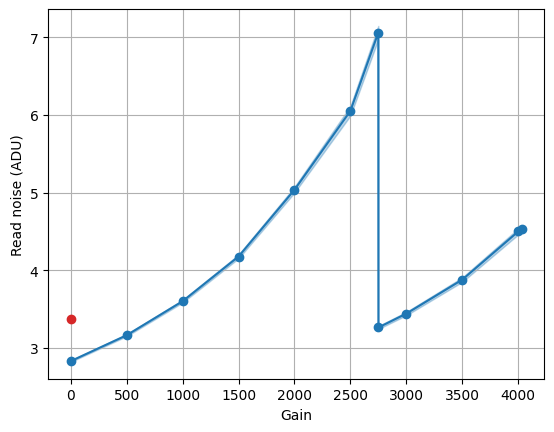

Gain:  0.0  Read noise:  3.373707159787286  ADU
Gain:  0.0  Read noise:  2.8284271247461903  ADU
Gain:  500.0  Read noise:  3.1622776601683795  ADU
Gain:  1000.0  Read noise:  3.6  ADU
Gain:  1500.0  Read noise:  4.17612260356422  ADU
Gain:  2000.0  Read noise:  5.035871324805669  ADU
Gain:  2500.0  Read noise:  6.053098380168622  ADU
Gain:  2749.0  Read noise:  7.059745037889115  ADU
Gain:  2750.0  Read noise:  3.2619012860600183  ADU
Gain:  3000.0  Read noise:  3.4409301068170506  ADU
Gain:  3500.0  Read noise:  3.8781438859330635  ADU
Gain:  4000.0  Read noise:  4.498888751680798  ADU
Gain:  4030.0  Read noise:  4.534313619501853  ADU


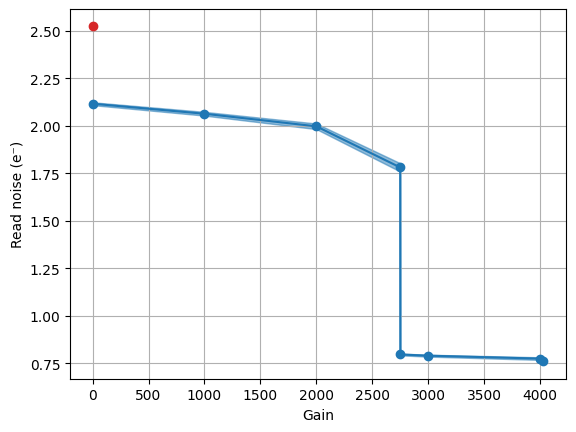

Gain:  0.0  Read noise:  2.524947608021557  + 0.0015117043404458627  - 0.001477306281817412  e⁻
Gain:  0.0  Read noise:  2.116849496665107  + 0.00762081562062749  - 0.007447407861251975  e⁻
Gain:  1000.0  Read noise:  2.0640100628744524  + 0.010008836246316702  - 0.009791226963485097  e⁻
Gain:  2000.0  Read noise:  1.9977046962535887  + 0.01492203473814621  - 0.014544995324993999  e⁻
Gain:  2749.0  Read noise:  1.7814568620930848  + 0.022305791306194336  - 0.021625887964665212  e⁻
Gain:  2750.0  Read noise:  0.7964569168466549  + 0.004834709765425755  - 0.004643757806300823  e⁻
Gain:  3000.0  Read noise:  0.7901352828496019  + 0.005140653392507137  - 0.004936559225595121  e⁻
Gain:  4000.0  Read noise:  0.7746824802235721  + 0.006947665635906216  - 0.00669059728677807  e⁻
Gain:  4030.0  Read noise:  0.7639448977994089  + 0.00695874605164154  - 0.006656376734414003  e⁻


In [40]:
#CONTINUATION: THIS NEEDS THE CELL ABOVE TO BE RUN FIRST AT LEAST ONCE

#Parameters
readFile = True #Set to True to load results from file, False if you already have the results in memory from the previous cell

#### Computations ####

#Load results from file
if readFile:
    results = np.load('../Results/gain-readNoise-CI-ADU.npy')
    gainVal = results[0]
    readNoise = results[1]
    RN_CI = results[2]

#Plot results
#Main measurement series
plt.fill_between(gainVal[1:], readNoise[1:] - RN_CI[1:], readNoise[1:] + RN_CI[1:], color='tab:blue', alpha=0.3)
plt.plot(gainVal[1:], readNoise[1:], '-o', color='tab:blue')
#Extra gain zero measurement
plt.errorbar(gainVal[0], readNoise[0], yerr=RN_CI[0], fmt='o', color='tab:red')
plt.xlabel('Gain')
plt.ylabel('Read noise (ADU)')
plt.grid()
plt.show()

#Print results
for i in range(len(gainVal)):
    print('Gain: ', gainVal[i], ' Read noise: ', readNoise[i], ' ADU')

#Conversion and plotting in e-
#WARNING: For this to work, the part below concerning the Overall System Gain needs to be run once on the machine
#         It needs the .npy result vector

OSG_vec = np.load('../Results/Gain-OSG-up-down.npy')
OSG = OSG_vec[1]
OSG_gainrange = OSG_vec[0]
OSG_up = OSG_vec[2]
OSG_down = OSG_vec[3]

RN_electrons = np.empty(len(OSG_gainrange) + 1) #+1 for the two gain zero measurements
RN_CI_electrons_up = np.empty(len(OSG_gainrange) + 1)
RN_CI_electrons_down = np.empty(len(OSG_gainrange) + 1)

indices = np.nonzero(np.in1d(gainVal, OSG_gainrange))[0] #Indices of the OSG values in the gain values
OSG = np.concatenate(([OSG[0]], OSG)) #Duplicate the gain zero value for the two measurements
OSG_up = np.concatenate(([OSG_up[0]], OSG_up))
OSG_down = np.concatenate(([OSG_down[0]], OSG_down))


for i, index in enumerate(indices):
    RN_electrons[i] = readNoise[index] * OSG[i]
    RN_CI_electrons_up[i] = RN_CI[index] * OSG_up[i]
    RN_CI_electrons_down[i] = RN_CI[index] * OSG_down[i]

#Plot results
#Main measurement series
plt.fill_between(OSG_gainrange, RN_electrons[1:] - RN_CI_electrons_down[1:], RN_electrons[1:] + RN_CI_electrons_up[1:], color='tab:blue', alpha=0.5)
plt.plot(OSG_gainrange, RN_electrons[1:], '-o', color='tab:blue')
#Extra gain zero measurement
plt.errorbar(OSG_gainrange[0], RN_electrons[0], yerr=[[RN_CI_electrons_down[0]], [RN_CI_electrons_up[0]]], fmt='o', color='tab:red')
plt.xlabel('Gain')
plt.ylabel('Read noise (e⁻)')
plt.grid()
plt.show()

#Print results
OSG_gainrange = np.concatenate(([0], OSG_gainrange)) #Add a second gain zero for the output
for i in range(len(OSG_gainrange)):
    print('Gain: ', OSG_gainrange[i], ' Read noise: ', RN_electrons[i], ' +', RN_CI_electrons_up[i], ' -', RN_CI_electrons_down[i], ' e⁻')

Old gain 0 value: 2.116849496665107  e⁻

100%|██████████| 35/35 [03:57<00:00,  6.78s/it]


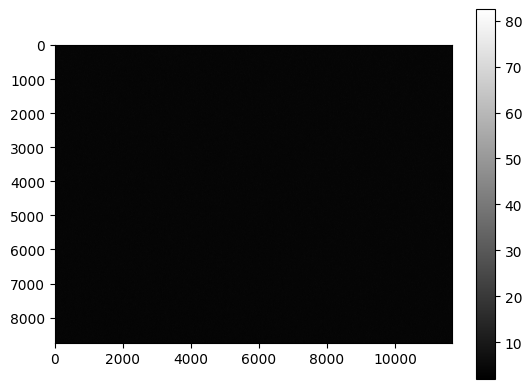

Read noise:  3.373707159787286 ADU =  2.52353295552089 e-


In [3]:
# LEGACY - NOT USED ANYMORE

#Bias at gain zero, with 100 bias frames, in ADU -> to give an exact value at gain 0
#Takes about 4' to run

dirName = '../Data/2024-04-19/ReadOutNoise/'

height = 11664
width = 8750

slice = 350
assert(width % slice == 0), 'Width must be a multiple of slice'

conv = 0.748 #Conversion factor from ADU to e- at gain 0

### Computations ###

stdMat = np.zeros((width, height))

for i in tqdm.tqdm(range(int(width / slice)), total=int(width / slice)):
    j = i * slice
    k = j + slice
    stack = np.zeros((slice, height, 100))
    n = 0
    for filename in os.listdir(dirName):
        with fits.open(dirName + filename) as hdul:
            #hdul.info()
            stack[:,:,n] = hdul[0].section[j:k,:]
        n += 1
    stdMat[j:k,:] = np.std(stack, axis=2)

plt.imshow(stdMat, cmap='gray') #Should have no structure
plt.colorbar()
plt.show()

read_noise = np.median(stdMat)
print('Read noise: ', read_noise, 'ADU = ', read_noise * conv, 'e-')
#Read noise: 3.373707159787286 ADU = 2.52353295552089 e

# Dark Current VS Temperature

100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


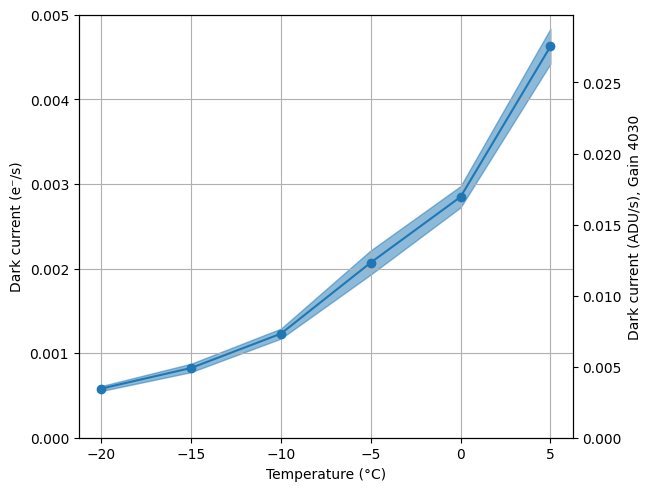

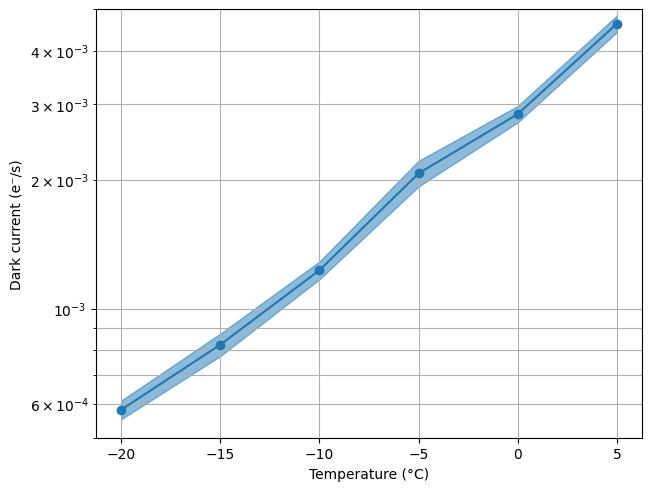

Temperature:  5 °C --> Dark current:  0.00463  + 0.00021   -0.00020 e⁻/s
Temperature:  0 °C --> Dark current:  0.00285  + 0.00013   -0.00012 e⁻/s
Temperature:  -5 °C --> Dark current:  0.00207  + 0.00014   -0.00014 e⁻/s
Temperature:  -10 °C --> Dark current:  0.00123  + 0.00006   -0.00006 e⁻/s
Temperature:  -15 °C --> Dark current:  0.00082  + 0.00005   -0.00005 e⁻/s
Temperature:  -20 °C --> Dark current:  0.00058  + 0.00003   -0.00003 e⁻/s


In [19]:
#Data directory
dir = '../Data/2024-04-19/DarkCurrent/'
#These exposures were done at a gain of 4030 to increase the resolution and allow a signal detection in reasonable time

tempRange = [5, 0, -5, -10, -15, -20] #For temperature dependency
#tempRange = [-5] #For a single temp, dev purposes

#Conversion factor from ADU to e- at relevant gain
conversion = 0.168 #e-/ADU
conv_int = 0.004 #e-/ADU  -  Uncertainty in conversion factor (confidence interval, 95%)

PlotAll = False #Set to True to plot all fits NOTE: This currently doesn't work with parallel processing

#NOTE: The -5°C data has two outliers that were removed manually

### Computations ###

tempLen = len(tempRange)
DarkCurrent = np.zeros(tempLen)
conf_ints = np.zeros((tempLen,2)) #Confidence intervals, first for the slope, second for the intercept

#Function to find the dark current for a given temperature
def dark_fit(j, tempRange, dir):
    dirName = dir + str(tempRange[j]) + 'C/'
    #Extract data
    files = os.listdir(dirName)
    for f in files: #Skip non-fits files and directories
        if not f.endswith('.fits'):
            files.remove(f)
    DataPoints = np.zeros((len(files),2))
    i = 0
    for filename in files:
        #if not filename.endswith('.fits'): continue #Skip non-fits files and directories
        with fits.open(dirName + filename) as hdul:
            DataPoints[i, 0] = hdul[0].header['EXPTIME']
            DataPoints[i, 1] = np.mean(hdul[0].data)
            i += 1
    #Fit a line to the data
    coeff, cov = np.polyfit(DataPoints[:,0], DataPoints[:,1], 1, cov=True)
    std_err = np.sqrt(np.diag(cov))
    #Calculate confidence intervals
    t = stats.t.ppf(0.975, len(DataPoints) - 2)
    conf_int = t * std_err
    
    #Plot fit
    if PlotAll:
        #Prepare functions
        x = np.linspace(0, 120, 100)
        poly_function = np.poly1d(coeff)
        y = poly_function(x)
        y_up = np.poly1d(coeff + conf_int)(x)
        y_down = np.poly1d(coeff - conf_int)(x)
        #Plot
        fig, ax = plt.subplots(layout='constrained')
        ax2 = ax.twinx()
        ax2.bar(DataPoints[:,0], poly_function(DataPoints[:,0]) - DataPoints[:,1], width=5, alpha=0.1, color='black')
        ax2.set_ylabel('Residuals / ADU')
        ax2.plot([0,120],[0, 0], color='black', alpha=0.3, linestyle='dotted')
        ax.plot(DataPoints[:,0], DataPoints[:,1], linestyle='', marker='o')
        ax.plot(x,y_up, linestyle='--', color='orange', alpha=0.5)
        ax.plot(x,y_down, linestyle='--', color='orange', alpha=0.5)
        ax.plot(x,y, linestyle='-', color='orange')
        ax.set_xlabel('Exposure / s')
        ax.set_ylabel('Mean Signal / ADU')
        #Print info
        DarkCurrent = coeff[0]
        #print('Dark current: ', DarkCurrent, '+/-', conf_int[0], 'ADU/s')
        ax.text(20, y[len(y)-5], 'Temperature: ' + str(tempRange[j]) + '°C')
        ax.text(20, y[len(y)-10], 'Dark current: ' + '{:.3e}'.format(DarkCurrent) + '+/-' + '{:.3e}'.format(conf_int[0]) + ' ADU/s')
        plt.show()

    return j, coeff[0], conf_int

#Parallel processing
cores_used = min(num_cores, tempLen)
with concurrent.futures.ProcessPoolExecutor(cores_used) as executor:
    results = [executor.submit(dark_fit, j, tempRange, dir) for j in range(tempLen)] #Submit all tasks
    for result in tqdm.tqdm(concurrent.futures.as_completed(results), total=tempLen): #As each task finishes
        DarkCurrent[result.result()[0]] = result.result()[1] #Save the result in the correct index
        conf_ints[result.result()[0]] = result.result()[2]

#Convert to e-
dc_up = (DarkCurrent + conf_ints[:,0]) * (conversion + conv_int)
dc_down = (DarkCurrent - conf_ints[:,0]) * (conversion - conv_int)
DarkCurrent *= conversion #WARNING: This needs to be done AFTER the confidence intervals are calculated


#Plot results
fig, ax = plt.subplots(layout='constrained')
ax2 = ax.twinx()
ax.plot(tempRange, DarkCurrent, '-o', color='tab:blue')
ax.fill_between(tempRange, dc_up, dc_down, color='tab:blue', alpha=0.5)
ax.set_ylim(0, 0.005)
ax2.set_ylim(0, 0.005 /conversion)
ax.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Dark current (ADU/s), Gain 4030')
ax.set_ylabel('Dark current (e⁻/s)')
ax.grid()
plt.show()

#Logarithmic plot
fig, ax = plt.subplots(layout='constrained')
ax.semilogy(tempRange, DarkCurrent, '-o', color='tab:blue')
ax.fill_between(tempRange, dc_up, dc_down, color='tab:blue', alpha=0.5)
ax.set_ylim(5e-4, 0.005)
ax.grid(which='both')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Dark current (e⁻/s)')
plt.show()


#Print results
for i in range(tempLen):
    print('Temperature: ', tempRange[i], '°C --> Dark current: ', "%.5f" % DarkCurrent[i], ' +', "%.5f" % (dc_up[i] - DarkCurrent[i]), ' ', "%.5f" % (dc_down[i] - DarkCurrent[i]), 'e⁻/s') 


#Save results to file
result = np.array([tempRange, DarkCurrent, dc_up, dc_down])
#np.save('../Results/temps-DarkCurr-Up-Down.npy', result) #Commented out to avoid overwriting

# Full-Well Capacity VS Gain

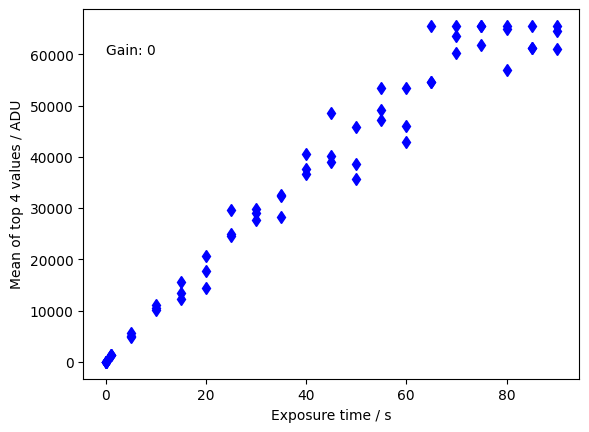

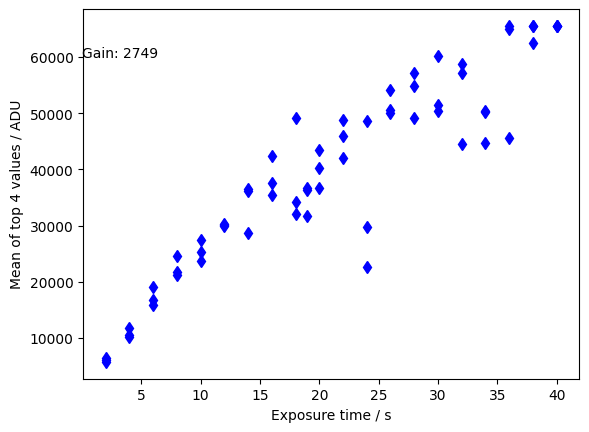

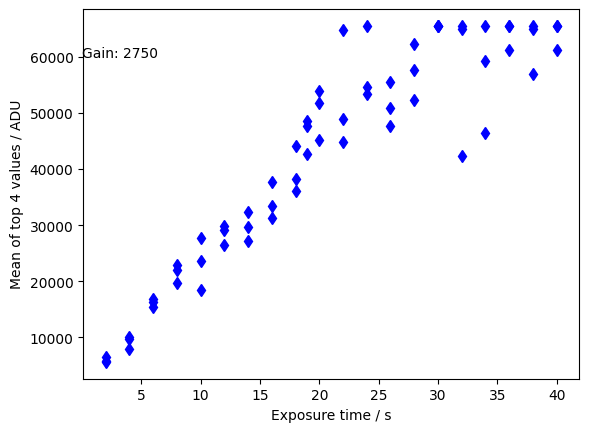

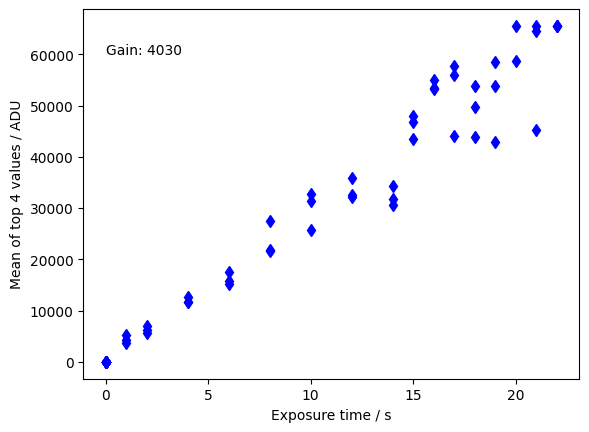

In [50]:
#Legacy data:
#dirName = '../Data/2024-03-19/FWCapVSGain-Megrez/'
#gain = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4030]

#New data:
dirName = '../Data/2024-05-09/FWCap/'
gain = [0, 2749, 2750, 4030]

#gain = [0] #For tests with a single gain value

expNum = 63 #Maximal number of exposure per gain value, actually not constant in my data -> produces points at (0,0)

### Computations ###

signal = np.zeros((len(gain),expNum, 2)) #First dimension is gain, the second is the individual files and the third is for the mean signal and the exp time

for i in range(len(gain)):
    files = os.listdir(dirName+'Gain'+str(gain[i]))
    for j in range(len(files)):
        with fits.open(dirName+'Gain'+str(gain[i])+'/'+files[j]) as hdu:
            data = hdu[0].data
            data = np.sort(data, axis=None)
            signal[i,j,0] = np.mean(data[-4]) #Take the mean of the top 4 pixels
            signal[i,j,1] = hdu[0].header['EXPTIME']
    #Plot the results
    plt.plot(signal[i,:,1], signal[i,:,0], 'bd')
    plt.xlabel('Exposure time / s')
    plt.ylabel('Mean of top 4 values / ADU')
    plt.text(0, 60000, 'Gain: '+str(gain[i]))
    plt.show()
        
#TODO: redo the measurements with potentially another star, with a quieter atmosphere. The current data is clearly flawed

In [54]:
# Compute the full-well capacity from the overall system gain
# NOTE: This requires the OSG values to be saved to disk (the OSG section needs to be run at least once)

#Parameters
Nmax = 65535 #Maximum pixel value (for 16-bit camera: 2^16 - 1 = 65535)

#### Computations ####

#Load the OSG values
OSG_vec = np.load('../Results/Gain-OSG-up-down.npy')
OSG = OSG_vec[1]
OSG_gainrange = OSG_vec[0]
OSG_up = OSG_vec[2]
OSG_down = OSG_vec[3]

#Compute the full-well capacity and CI according to the formula: FWC = OSG * N_max
FWC = OSG * Nmax
FWC_CI_up = OSG_up * Nmax
FWC_CI_down = OSG_down * Nmax

#Print results
for i in range(len(OSG_gainrange)):
    print('Gain: ', OSG_gainrange[i], ' Full-well capacity: ', int(FWC[i]), ' +', int(FWC_CI_up[i] - FWC[i]), ' -', int(FWC[i] - FWC_CI_down[i]), ' e⁻')

Gain:  0.0  Full-well capacity:  49047  + 571  - 558  e⁻
Gain:  1000.0  Full-well capacity:  37573  + 417  - 408  e⁻
Gain:  2000.0  Full-well capacity:  25997  + 336  - 328  e⁻
Gain:  2749.0  Full-well capacity:  16537  + 259  - 252  e⁻
Gain:  2750.0  Full-well capacity:  16001  + 328  - 316  e⁻
Gain:  3000.0  Full-well capacity:  15048  + 311  - 298  e⁻
Gain:  4000.0  Full-well capacity:  11284  + 216  - 208  e⁻
Gain:  4030.0  Full-well capacity:  11041  + 250  - 239  e⁻


# Overall System Gain

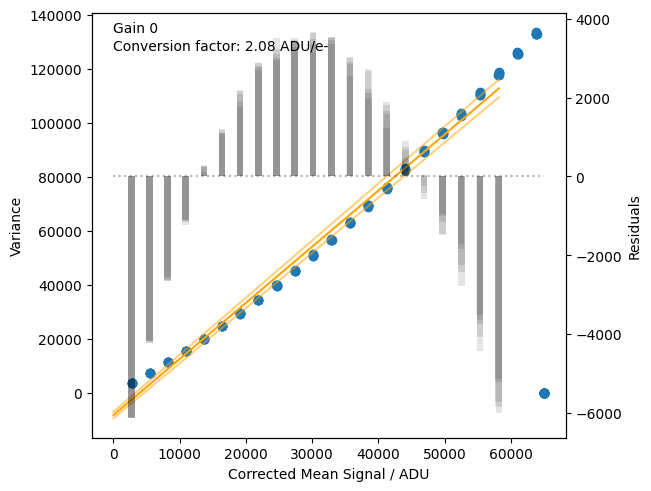

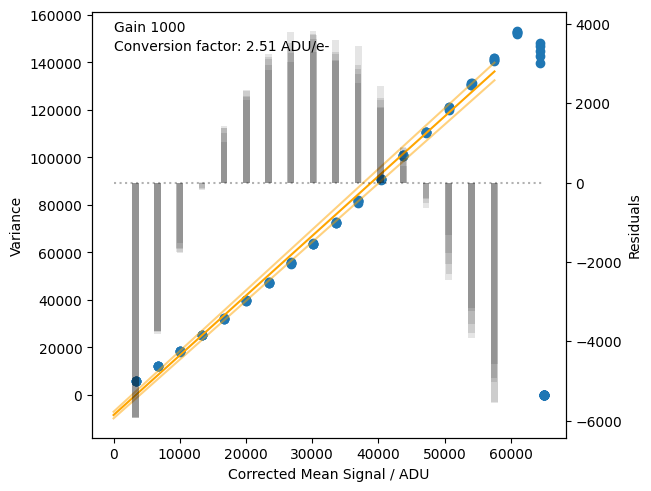

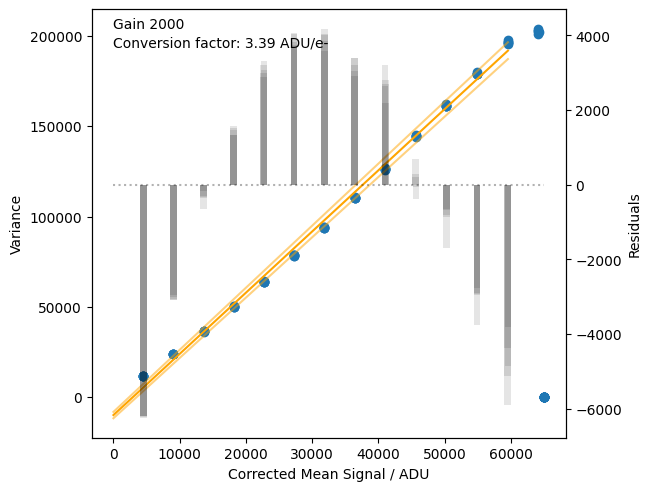

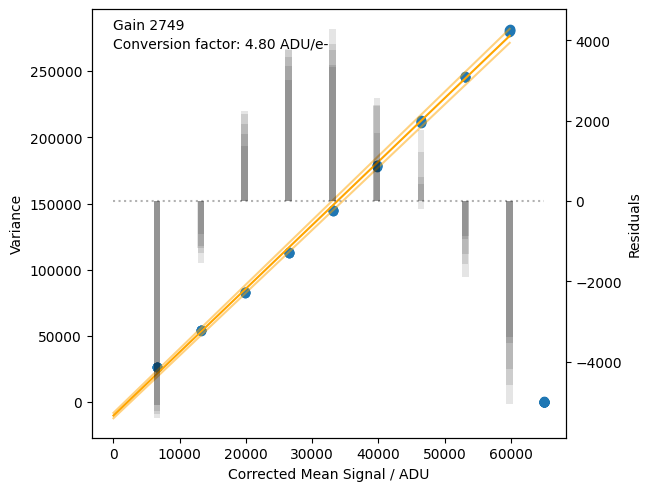

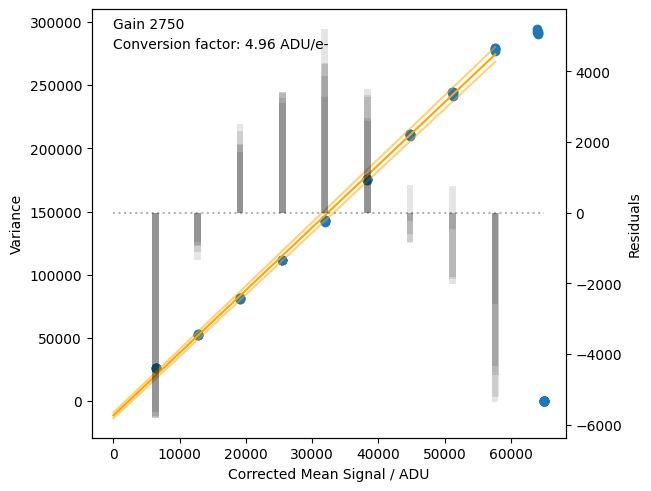

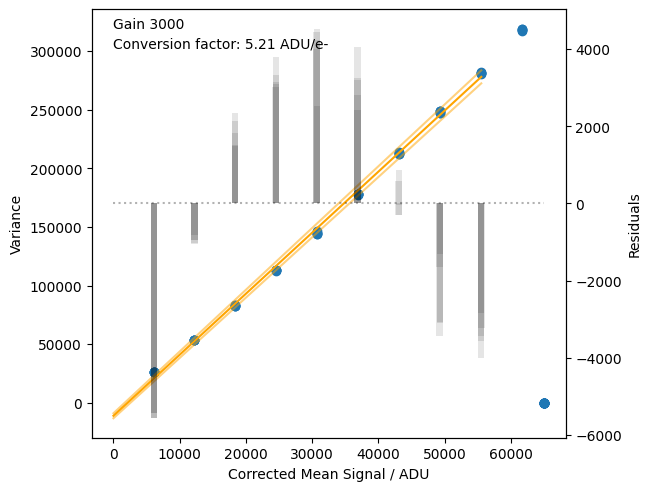

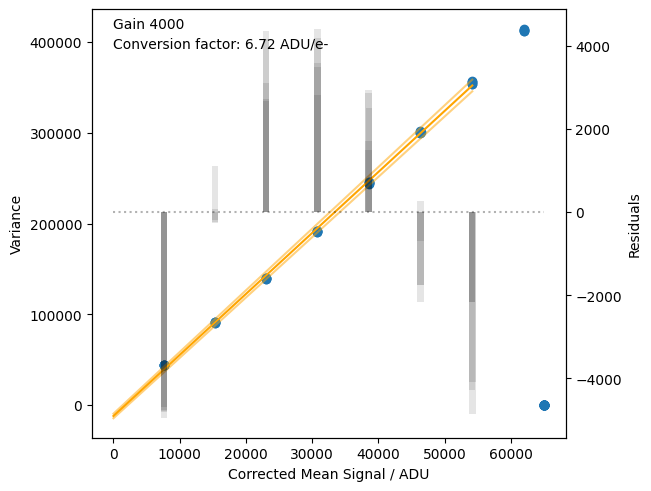

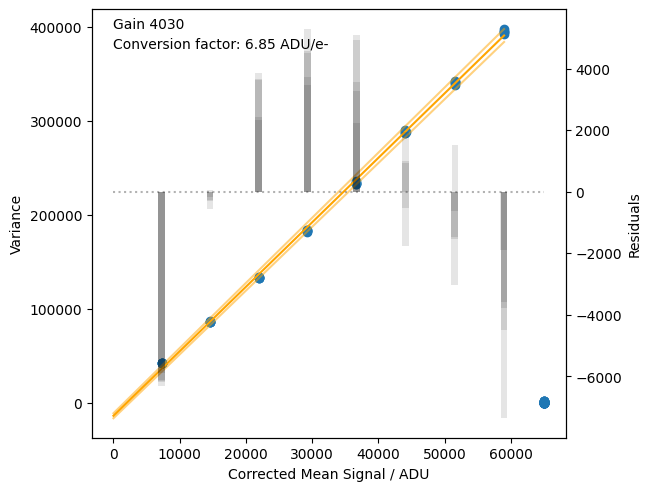

Gain:  0  -> Conversion Factor:  0.481  + 0.008  -0.008 e-/ADU
Gain:  1000  -> Conversion Factor:  0.398  + 0.006  -0.006 e-/ADU
Gain:  2000  -> Conversion Factor:  0.295  + 0.004  -0.004 e-/ADU
Gain:  2749  -> Conversion Factor:  0.208  + 0.002  -0.002 e-/ADU
Gain:  2750  -> Conversion Factor:  0.202  + 0.003  -0.002 e-/ADU
Gain:  3000  -> Conversion Factor:  0.192  + 0.002  -0.002 e-/ADU
Gain:  4000  -> Conversion Factor:  0.149  + 0.002  -0.002 e-/ADU
Gain:  4030  -> Conversion Factor:  0.146  + 0.002  -0.002 e-/ADU


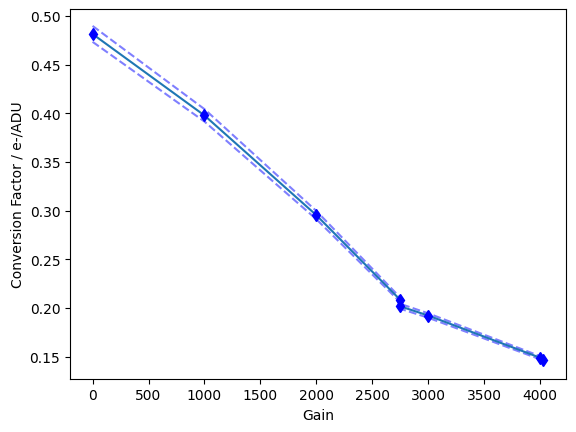

In [33]:
# WARNING: THIS IS LEGACY CODE, WITH ONLY A LINEAR FIT AND USING DARKS
# THIS GIVES INCORRECT RESULTS


# Directories of light and dark files
dirLight = '../Data/2024-05-09/SysGain/'
dirDark = '../Data/2024-05-09/SysGainDARK/'

#Choose whether to plot all gain values individually
plotAll = True

#Gain values available
gainRange = [0, 1000, 2000, 2749, 2750, 3000, 4000, 4030]
#gainRange = [0, 1000] #For testing

### Computations ###

#Result vector
OSGains = []
conf_ints = []

for gain in gainRange:

    #Read the dark files into data and exptime arrays
    filesDark = os.listdir(dirDark + 'Gain' + str(gain))
    data = np.empty((len(filesDark), 398,400)) #The two pixel rows "missing" are to correct a data error, see lab journal
    exptime = np.empty(len(filesDark))
    for i, filename in enumerate(filesDark):
        with fits.open(dirDark + 'Gain' + str(gain) + '/' + filename) as hdu:
            data[i] = hdu[0].section[:398, :]
            exptime[i] = hdu[0].header['EXPTIME']
    
    #Compute the master darks and store their mean in a dictionary with exptime as key
    uniqueExp, numExptimes = np.unique(exptime, return_counts=True) #Get all unique exposure times
    mDarks = {} #Instanciate dict
    for et in uniqueExp:
        ind = np.where(exptime == et)[0] #Find all elements with the same exptime
        masterDark = np.median(data[ind], axis=0)
        mDarks[et] = np.mean(masterDark) #Add to dict

    #Read the light files into data and exptime arrays. Compute the std-dev 
    filesLight = os.listdir(dirLight + 'Gain' + str(gain))
    data = np.empty((len(filesLight), 398, 400))
    exptime = np.empty(len(filesLight))
    variance = np.empty(len(filesLight))
    for i, filename in enumerate(filesLight):
        with fits.open(dirLight + 'Gain' + str(gain) + '/' + filename) as hdu:
            data[i] = hdu[0].section[:398,:]
            exptime[i] = hdu[0].header['EXPTIME']
            variance[i] = np.var(data[i])

    #Compute the slope
    cmds = np.empty(len(data)) #Corrected mean digital signal = mean signal - mean dark signal
    for i in range(len(data)):
        cmds[i] = np.mean(data[i]) - mDarks[exptime[i]]
    #select only the points with a cmds under 60000 to compute the slope, so as to remain in the linear part of the sensor
    ind = np.where(cmds<60000)[0]

    #Fit a line to the data
    fit = stats.linregress(cmds[ind], variance[ind])
    slope = fit.slope
    intercept = fit.intercept
    std_err = fit.stderr
    intercept_err = fit.intercept_stderr
    OSGains.append(slope)

    #Estimate 95-percentile confidence interval of the slope
    dof = len(ind) - 2 #Degrees of freedom
    t_val = stats.t.ppf(0.975, dof) #Two-tailed t-value
    conf_int = t_val * std_err #Confidence interval
    conf_ints.append(conf_int)
    conf_int_intercept = t_val * intercept_err

    #Plot the data, fit and residuals
    if plotAll:
        x = np.linspace(0, np.max(cmds[ind]), 100)
        poly_function = np.poly1d([slope, intercept])
        y = poly_function(x)
        y_up = np.poly1d([slope + conf_int, intercept + conf_int_intercept])(x)
        y_down = np.poly1d([slope - conf_int, intercept - conf_int_intercept])(x)

        fig, ax = plt.subplots(layout='constrained')
        ax2 = ax.twinx()
        ax2.bar(cmds[ind], poly_function(cmds[ind]) - variance[ind], width=1000, alpha=0.1, color='black')
        ax2.set_ylabel('Residuals')
        ax2.plot([0,np.max(cmds)],[0, 0], color='black', alpha=0.3, linestyle='dotted')
        ax.plot(cmds, variance, linestyle='', marker='o')
        ax.plot(x, y_up, alpha = 0.5, color='orange')
        ax.plot(x, y_down, alpha = 0.5, color='orange')
        ax.plot(x, y, color='orange')
        ax.set_xlabel('Corrected Mean Signal / ADU')
        ax.set_ylabel('Variance')
        ax.text(0, np.max(variance), 'Gain ' + str(gain))
        ax.text(0, np.max(variance)*19/20, 'Conversion factor: ' + "%.2f" % slope + ' ADU/e-')

        plt.show()

#Calculate final values and error propagation
OSGains = np.array(OSGains)
conf_ints = np.array(conf_ints)
conf_down = 1 / (OSGains + conf_ints)
conf_up = 1 / (OSGains - conf_ints)
OSGains = 1 / OSGains

#Plot the results
plt.plot(gainRange, conf_up, 'b--', alpha=0.5)
plt.plot(gainRange, conf_down, 'b--', alpha=0.5)
plt.plot(gainRange, OSGains)
plt.plot(gainRange, OSGains, 'bd')
plt.xlabel('Gain')
plt.ylabel('Conversion Factor / e-/ADU')

for i in range(len(gainRange)):
    print('Gain: ', gainRange[i], ' -> Conversion Factor: ', "%.3f" % OSGains[i], ' +', "%.3f" % (conf_up[i] - OSGains[i]), ' -'  "%.3f" % (OSGains[i] - conf_down[i]), 'e-/ADU')

#Save results to a numpy array on disk
# DISABLED SINCE LEGACY

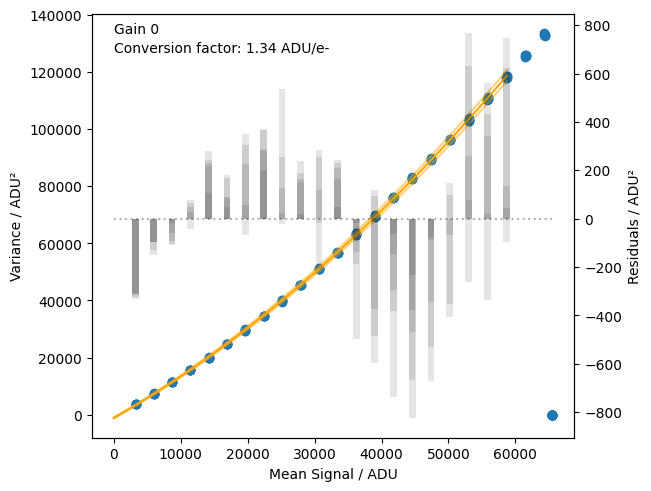

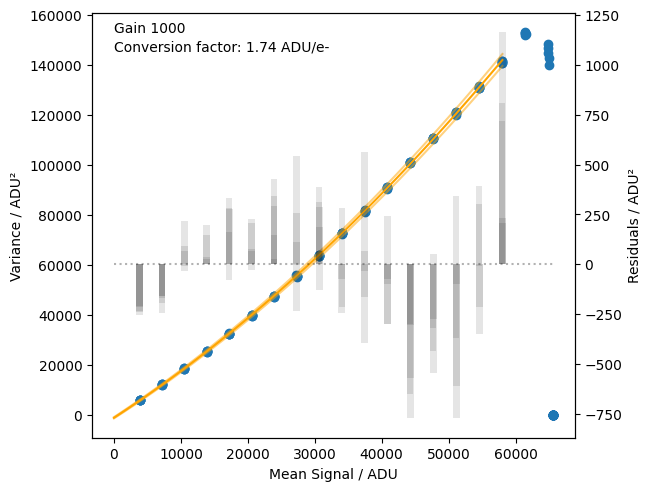

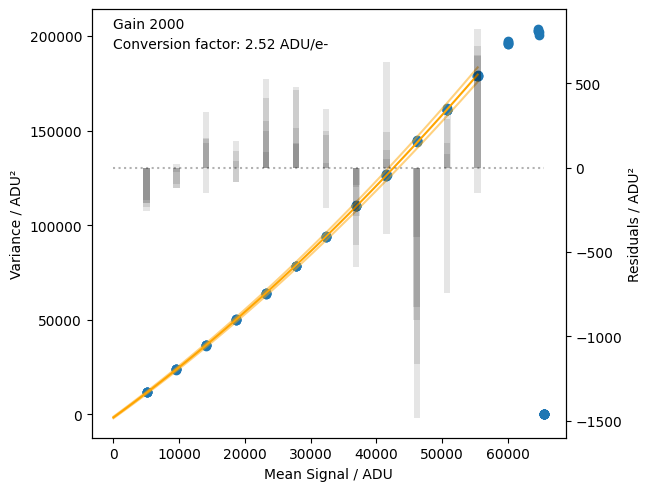

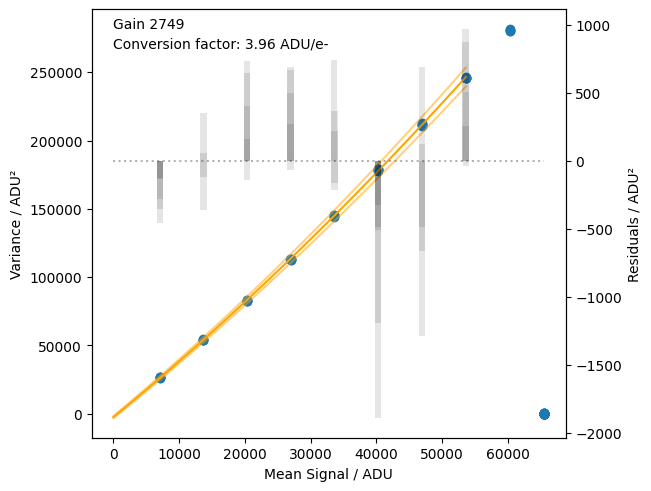

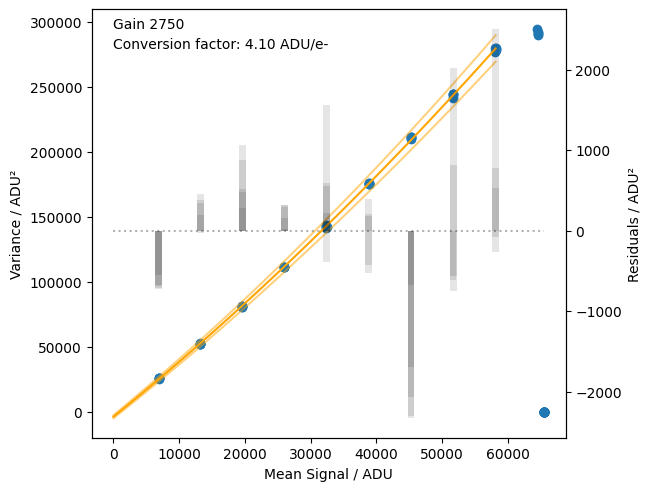

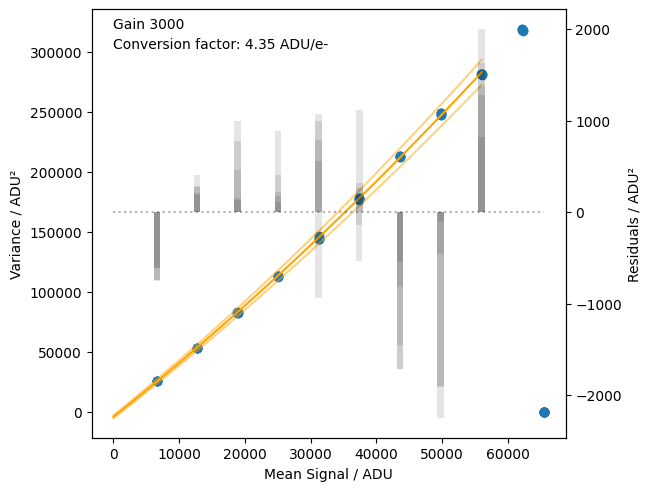

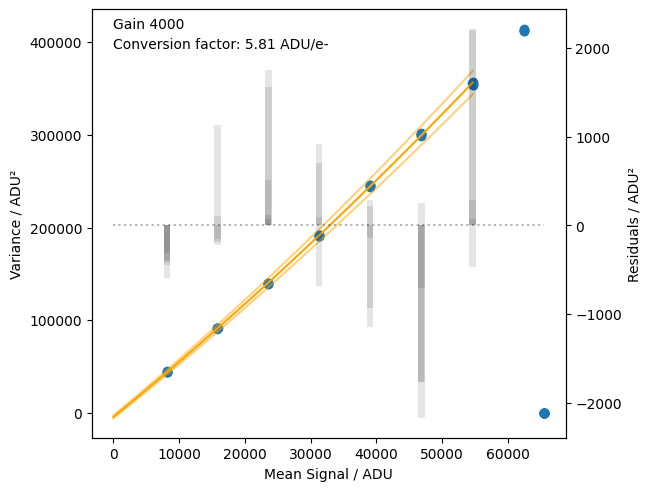

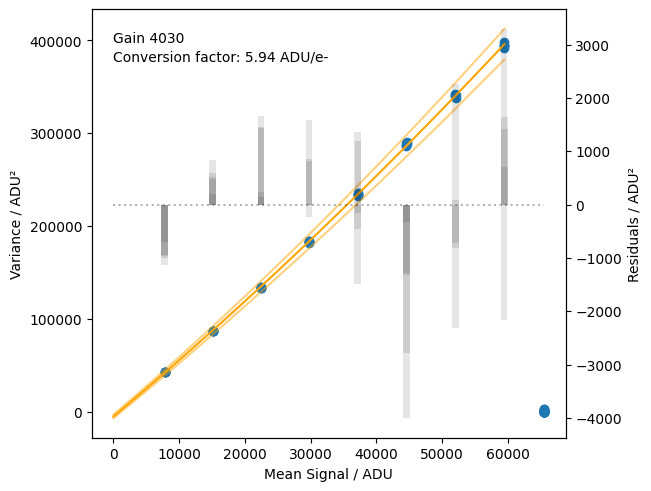

Gain:  0  -> Conversion Factor:  0.748  + 0.009  -0.009 e-/ADU
Gain:  1000  -> Conversion Factor:  0.573  + 0.006  -0.006 e-/ADU
Gain:  2000  -> Conversion Factor:  0.397  + 0.005  -0.005 e-/ADU
Gain:  2749  -> Conversion Factor:  0.252  + 0.004  -0.004 e-/ADU
Gain:  2750  -> Conversion Factor:  0.244  + 0.005  -0.005 e-/ADU
Gain:  3000  -> Conversion Factor:  0.230  + 0.005  -0.005 e-/ADU
Gain:  4000  -> Conversion Factor:  0.172  + 0.003  -0.003 e-/ADU
Gain:  4030  -> Conversion Factor:  0.168  + 0.004  -0.004 e-/ADU


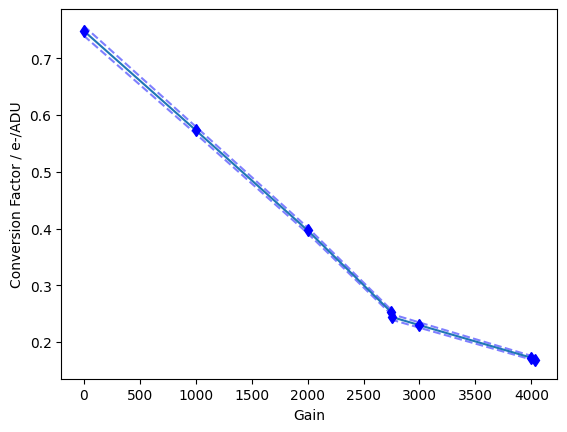

In [24]:
#Directories of light files
# This directroy should contain one subdirectory for each gain value named 'GainX' where X is the gain value
dirLight = '../Data/2024-05-09/SysGain/'

#Choose whether to plot all gain values individually
plotAll = True

#Gain values available
gainRange = [0, 1000, 2000, 2749, 2750, 3000, 4000, 4030]
#gainRange = [0] #For testing

### Computations ###

#Result vector
OSGains = []
conf_ints = []

for gain in gainRange:

    #Read the light files into data and exptime arrays. Compute the variance
    filesLight = os.listdir(dirLight + 'Gain' + str(gain))
    data = np.empty((len(filesLight), 398, 400))
    exptime = np.empty(len(filesLight))
    variance = np.empty(len(filesLight))
    for i, filename in enumerate(filesLight):
        with fits.open(dirLight + 'Gain' + str(gain) + '/' + filename) as hdu:
            data[i] = hdu[0].section[:398,:]
            exptime[i] = hdu[0].header['EXPTIME']
            variance[i] = np.var(data[i])

    #Compute the slope
    mean_sig = np.mean(data, axis=(1,2)) #Mean signal
    #select only the points with a mean signal under 60000 to compute the slope, so as to remain in the linear part of the sensor
    ind = np.where(mean_sig<60000)[0]

    #Fit a quadratic function to the data
    fit, cov = np.polyfit(mean_sig[ind], variance[ind], 2, cov=True)
    std_err_vec = np.sqrt(np.diag(cov))

    poly_function = np.poly1d(fit)
    quad = fit[0] #Quadratic coefficient -> P_N^2
    slope = fit[1] #Linear coefficient -> 1/K
    intercept = fit[2] #Constant -> sig_READ^2

    quad_err = std_err_vec[0]
    lin_err = std_err_vec[1]
    intercept_err = std_err_vec[2]

    OSGains.append(slope)


    #Estimate 95-percentile confidence interval of the slope
    dof = len(ind) - 2 #Degrees of freedom
    t_val = stats.t.ppf(0.975, dof) #Two-tailed t-value
    conf_int = t_val * lin_err #Confidence interval for 1/K
    conf_ints.append(conf_int)
    conf_int_quad = t_val * quad_err
    conf_int_intercept = t_val * intercept_err

    #Plot the data, fit and residuals
    if plotAll:
        x = np.linspace(0, np.max(mean_sig[ind]), 100)
        y = poly_function(x)
        y_up = np.poly1d([quad + conf_int_quad, slope + conf_int, intercept + conf_int_intercept])(x)
        y_down = np.poly1d([quad - conf_int_quad, slope - conf_int, intercept - conf_int_intercept])(x)

        fig, ax = plt.subplots(layout='constrained')
        ax2 = ax.twinx()
        ax2.bar(mean_sig[ind], poly_function(mean_sig[ind]) - variance[ind], width=1000, alpha=0.1, color='black')
        ax2.set_ylabel('Residuals / ADU²')
        ax2.plot([0,np.max(mean_sig)],[0, 0], color='black', alpha=0.3, linestyle='dotted')
        ax.plot(mean_sig, variance, linestyle='', marker='o')
        ax.plot(x, y_up, alpha = 0.5, color='orange')
        ax.plot(x, y_down, alpha = 0.5, color='orange')
        ax.plot(x, y, color='orange')
        ax.set_xlabel('Mean Signal / ADU')
        ax.set_ylabel('Variance / ADU²')
        ax.text(0, np.max(variance), 'Gain ' + str(gain))
        ax.text(0, np.max(variance)*19/20, 'Conversion factor: ' + "%.2f" % slope + ' ADU/e-')
        #plt.savefig('../Results/OSG-Fit-Gain0.pdf', format='pdf')
        plt.show()

#Calculate final values and error propagation
OSGains = np.array(OSGains)
conf_ints = np.array(conf_ints)
conf_down = 1 / (OSGains + conf_ints)
conf_up = 1 / (OSGains - conf_ints)
OSGains = 1 / OSGains

#Plot the results
plt.plot(gainRange, conf_up, 'b--', alpha=0.5)
plt.plot(gainRange, conf_down, 'b--', alpha=0.5)
plt.plot(gainRange, OSGains)
plt.plot(gainRange, OSGains, 'bd')
plt.xlabel('Gain')
plt.ylabel('Conversion Factor / e-/ADU')

for i in range(len(gainRange)):
    print('Gain: ', gainRange[i], ' -> Conversion Factor: ', "%.3f" % OSGains[i], ' +', "%.3f" % (conf_up[i] - OSGains[i]), ' -'  "%.3f" % (OSGains[i] - conf_down[i]), 'e-/ADU')

#Save results to a numpy array on disk
results = np.empty((4,len(OSGains)))
results[0] = gainRange
results[1] = OSGains
results[2] = conf_up
results[3] = conf_down
#np.save('../Results/Gain-OSG-up-down.npy', results) #Save the results, commented out to avoid overwriting